# Report

1. One wrong record found in ArgumentationTime feature, see ArgumentationTime feature visualization.  
2. The perjob features matrix is sparse. I doubt if the current features are all useful for research. Stefan said he needs more features for predicting his response, but the actual amount of predictors may be less than we thought.
3. Aggregate features all show long tail and right-skewed. But outliers may be meaningful for detecting players' behaviral pattern.  
4. One wrong record found in ExperimentationTime feature, see Aggregate feature visualization.
5. Interesting thing: Why there are more switch_job_count than job_completion?

In [1]:
import os
print(os.getcwd())
!pip install --quiet -r ../../requirements.txt

/workspaces/opengamedata-samples/AQUALAB/templates


# Environment Setup and Import

In [2]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tensorflow import keras

2023-03-15 16:45:48.782030: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-15 16:45:51.462156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-15 16:45:51.478986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:45:58.171206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [3]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Load Data

#### Please change `ogd_server` and `zip_name` if you want to get a file from a different location.
#### This cell will error if `ogd_server` and `zip_name` are invalid.

In [4]:
ogd_server = 'http://opengamedata.fielddaylab.wisc.edu/'
server_data_path = 'data/AQUALAB/'
dataset_name = "AQUALAB_20230101_to_20230131"
zip_name = f"{dataset_name}_7565f43_player-features.zip"

file_url = f"{ogd_server}{server_data_path}{zip_name}"

# download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {ogd_server}...")
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")

In [5]:
# Get file path and create data frame
tsv_name = f"{dataset_name}_7565f43_player-features.tsv"
survey_path = Path("./") / dataset_name / tsv_name
# if not survey_path.is_file():
#     !unzip ./{zipname} -d {dataset_name}
raw_data = pd.read_csv(survey_path, sep='\t')

In [6]:
#@markdown Do you want to filter player list?
Answer  = False#@param {type:"boolean"}
#@markdown Please change the file path if your player list is located differently.
PL_Path = "PlayerList.txt"#@param {type:"string"}
if Answer:
  player_list = pd.read_csv(JUPYTER_DIR / Path(PL_Path), sep='t', names=["Player"])
  raw_data = raw_data[raw_data.PlayerId.isin()]

# Cleaning and Transforms

## Data Overview

**Why are there so many na rows?** Sometimes, the na rows will be confusable for the users

In [7]:
#split depending on prefix, clean columns
cols_split = []
for col in raw_data.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job') or prefix.startswith('int') or prefix.startswith('obj') \
  or prefix.startswith('SA')  or prefix.startswith('Q'):
    cols_split.append(pieces[1])
  else:
    cols_split.append(col)
col_set = Counter(cols_split)
print(f"{len(raw_data.columns)} Columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

1359 Columns in 39 groups:
Counter({'JobActiveTime': 61,
         'JobArgumentationTime': 61,
         'JobCompletionTime': 61,
         'JobDiveSitesCount': 61,
         'JobDiveTime': 61,
         'JobExperimentationTime': 61,
         'JobGuideCount': 61,
         'JobHelpCount': 61,
         'JobHelpCount-ByTask': 61,
         'JobLocationChanges': 61,
         'JobLocationChanges-ByTask': 61,
         'JobModelingTime': 61,
         'JobTasksCompleted': 61,
         'SyncCompletionTime': 61,
         'JobsAttempted': 61,
         'JobsAttempted-job-name': 61,
         'JobsAttempted-num-starts': 61,
         'JobsAttempted-num-completes': 61,
         'JobsAttempted-percent-complete': 61,
         'JobsAttempted-avg-time-per-attempt': 61,
         'JobsAttempted-std-dev-per-attempt': 61,
         'JobsAttempted-job-difficulties': 61,
         'PlayerID': 1,
         'SessionCount': 1,
         'ActiveTime': 1,
         'JobsCompleted': 1,
         'SessionDiveSitesCount': 1,
     

In [8]:
#size of df
raw_data.shape

(955, 1359)

In [9]:
raw_data.describe(include = 'all')

PlayerID  SessionCount ActiveTime JobsCompleted   
count          954    955.000000        955           955  \
unique         954           NaN        758           160   
top     AbruptSign           NaN    0:00:05            []   
freq             1           NaN          8           529   
mean           NaN      2.105759        NaN           NaN   
std            NaN      3.047891        NaN           NaN   
min            NaN      1.000000        NaN           NaN   
25%            NaN      1.000000        NaN           NaN   
50%            NaN      1.000000        NaN           NaN   
75%            NaN      2.000000        NaN           NaN   
max            NaN     43.000000        NaN           NaN   

        SessionDiveSitesCount  SessionGuideCount  SessionHelpCount SessionID   
count              955.000000              955.0        955.000000       955  \
unique                    NaN                NaN               NaN         1   
top                       NaN                NaN               NaN    player   
freq                      NaN                NaN               NaN       955   
mean                 1.991623                0.0          7.014660       NaN   
std                  3.147981                0.0         17.745457       NaN   
min                  0.000000                0.0          0.000000       NaN   
25%                  0.000000                0.0          0.000000       NaN   
50%                  1.000000                0.0          1.000000       NaN   
75%                  2.000000                0.0          6.000000       NaN   
max                 13.000000                0.0        250.000000       NaN   

        SessionJobsCompleted  SwitchJobsCount TopJobCompletionDestinations   
count             955.000000       955.000000                          955  \
unique                   NaN              NaN                          389   
top                      NaN              NaN                           {}   
freq                     NaN              NaN                          567   
mean                3.093194         8.380105                          NaN   
std                 6.708572        17.981502                          NaN   
min                 0.000000         0.000000                          NaN   
25%                 0.000000         1.000000                          NaN   
50%                 0.000000         1.000000                          NaN   
75%                 3.000000         7.000000                          NaN   
max                45.000000       151.000000                          NaN   

       TopJobSwitchDestinations TotalArgumentationTime TotalDiveTime   
count                       955                    955           955  \
unique                      288                    365           194   
top                          {}                0:00:00       0:00:00   
freq                        668                    463           472   
mean                        NaN                    NaN           NaN   
std                         NaN                    NaN           NaN   
min                         NaN                    NaN           NaN   
25%                         NaN                    NaN           NaN   
50%                         NaN                    NaN           NaN   
75%                         NaN                    NaN           NaN   
max                         NaN                    NaN           NaN   

       TotalExperimentationTime  job0_JobActiveTime  job1_JobActiveTime   
count                       955        9.550000e+02        9.550000e+02  \
unique                      279                 NaN                 NaN   
top                     0:00:00                 NaN                 NaN   
freq                        434                 NaN                 NaN   
mean                        NaN        1.103993e+05        9.099519e+03   
std                         NaN        6.954869e+05        8.395

In [10]:
#quick rundown of df
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Columns: 1359 entries, PlayerID to job60_JobsAttempted-job-difficulties
dtypes: float64(172), int64(568), object(619)
memory usage: 9.9+ MB


In [11]:
#any Player IDs that are NA
raw_data[raw_data.PlayerID.isna()]

PlayerID  SessionCount ActiveTime JobsCompleted  SessionDiveSitesCount   
0      NaN             1  No events            []                      0  \

   SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
0                  0                 0    player                     0  \

   SwitchJobsCount TopJobCompletionDestinations TopJobSwitchDestinations   
0                0                           {}                       {}  \

  TotalArgumentationTime TotalDiveTime TotalExperimentationTime   
0                0:00:00       0:00:00                  0:00:00  \

   job0_JobActiveTime  job1_JobActiveTime  job2_JobActiveTime   
0                 0.0                 0.0                 0.0  \

   job3_JobActiveTime  job4_JobActiveTime  job5_JobActiveTime   
0                 0.0                 0.0                 0.0  \

   job6_JobActiveTime  job7_JobActiveTime  job8_JobActiveTime   
0                 0.0                 0.0                 0.0  \

   job9_JobActiveTime  job10_JobActiveTime  job11_JobActiveTime   
0                 0.0                  0.0                  0.0  \

   job12_JobActiveTime  job13_JobActiveTime  job14_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job15_JobActiveTime  job16_JobActiveTime  job17_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job18_JobActiveTime  job19_JobActiveTime  job20_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job21_JobActiveTime  job22_JobActiveTime  job23_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job24_JobActiveTime  job25_JobActiveTime  job26_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job27_JobActiveTime  job28_JobActiveTime  job29_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job30_JobActiveTime  job31_JobActiveTime  job32_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job33_JobActiveTime  job34_JobActiveTime  job35_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job36_JobActiveTime  job37_JobActiveTime  job38_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job39_JobActiveTime  job40_JobActiveTime  job41_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job42_JobActiveTime  job43_JobActiveTime  job44_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job45_JobActiveTime  job46_JobActiveTime  job47_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job48_JobActiveTime  job49_JobActiveTime  job50_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job51_JobActiveTime  job52_JobActiveTime  job53_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job54_JobActiveTime  job55_JobActiveTime  job56_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job57_JobActiveTime  job58_JobActiveTime  job59_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job60_JobActiveTime job0_JobArgumentationTime job1_JobArgumentationTime   
0                  0.0                   0:00:00                   0:00:00  \

  job2_JobArgumentationTime job3_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job4_JobArgumentationTime job5_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job6_JobArgumentationTime job7_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job8_JobArgumentationTime job9_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job10_JobArgumentationTime job11_JobArgumentationTime   
0               

In [12]:
raw_data[raw_data.isnull().any(axis = 1)].head(10)

PlayerID  SessionCount ActiveTime JobsCompleted  SessionDiveSitesCount   
0      NaN             1  No events            []                      0  \

   SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
0                  0                 0    player                     0  \

   SwitchJobsCount TopJobCompletionDestinations TopJobSwitchDestinations   
0                0                           {}                       {}  \

  TotalArgumentationTime TotalDiveTime TotalExperimentationTime   
0                0:00:00       0:00:00                  0:00:00  \

   job0_JobActiveTime  job1_JobActiveTime  job2_JobActiveTime   
0                 0.0                 0.0                 0.0  \

   job3_JobActiveTime  job4_JobActiveTime  job5_JobActiveTime   
0                 0.0                 0.0                 0.0  \

   job6_JobActiveTime  job7_JobActiveTime  job8_JobActiveTime   
0                 0.0                 0.0                 0.0  \

   job9_JobActiveTime  job10_JobActiveTime  job11_JobActiveTime   
0                 0.0                  0.0                  0.0  \

   job12_JobActiveTime  job13_JobActiveTime  job14_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job15_JobActiveTime  job16_JobActiveTime  job17_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job18_JobActiveTime  job19_JobActiveTime  job20_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job21_JobActiveTime  job22_JobActiveTime  job23_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job24_JobActiveTime  job25_JobActiveTime  job26_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job27_JobActiveTime  job28_JobActiveTime  job29_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job30_JobActiveTime  job31_JobActiveTime  job32_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job33_JobActiveTime  job34_JobActiveTime  job35_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job36_JobActiveTime  job37_JobActiveTime  job38_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job39_JobActiveTime  job40_JobActiveTime  job41_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job42_JobActiveTime  job43_JobActiveTime  job44_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job45_JobActiveTime  job46_JobActiveTime  job47_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job48_JobActiveTime  job49_JobActiveTime  job50_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job51_JobActiveTime  job52_JobActiveTime  job53_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job54_JobActiveTime  job55_JobActiveTime  job56_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job57_JobActiveTime  job58_JobActiveTime  job59_JobActiveTime   
0                  0.0                  0.0                  0.0  \

   job60_JobActiveTime job0_JobArgumentationTime job1_JobArgumentationTime   
0                  0.0                   0:00:00                   0:00:00  \

  job2_JobArgumentationTime job3_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job4_JobArgumentationTime job5_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job6_JobArgumentationTime job7_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job8_JobArgumentationTime job9_JobArgumentationTime   
0                   0:00:00                   0:00:00  \

  job10_JobArgumentationTime job11_JobArgumentationTime   
0               

## Data Cleaning

In [13]:
df_session = raw_data.dropna()
df_session.describe(include="all")

PlayerID  SessionCount ActiveTime JobsCompleted   
count          954    954.000000        954           954  \
unique         954           NaN        758           160   
top     AbruptSign           NaN    0:00:05            []   
freq             1           NaN          8           528   
mean           NaN      2.106918        NaN           NaN   
std            NaN      3.049279        NaN           NaN   
min            NaN      1.000000        NaN           NaN   
25%            NaN      1.000000        NaN           NaN   
50%            NaN      1.000000        NaN           NaN   
75%            NaN      2.000000        NaN           NaN   
max            NaN     43.000000        NaN           NaN   

        SessionDiveSitesCount  SessionGuideCount  SessionHelpCount SessionID   
count              954.000000              954.0        954.000000       954  \
unique                    NaN                NaN               NaN         1   
top                       NaN                NaN               NaN    player   
freq                      NaN                NaN               NaN       954   
mean                 1.993711                0.0          7.022013       NaN   
std                  3.148970                0.0         17.753309       NaN   
min                  0.000000                0.0          0.000000       NaN   
25%                  0.000000                0.0          0.000000       NaN   
50%                  1.000000                0.0          1.000000       NaN   
75%                  2.000000                0.0          6.000000       NaN   
max                 13.000000                0.0        250.000000       NaN   

        SessionJobsCompleted  SwitchJobsCount TopJobCompletionDestinations   
count             954.000000       954.000000                          954  \
unique                   NaN              NaN                          389   
top                      NaN              NaN                           {}   
freq                     NaN              NaN                          566   
mean                3.096436         8.388889                          NaN   
std                 6.711342        17.988883                          NaN   
min                 0.000000         0.000000                          NaN   
25%                 0.000000         1.000000                          NaN   
50%                 0.000000         1.000000                          NaN   
75%                 3.000000         7.000000                          NaN   
max                45.000000       151.000000                          NaN   

       TopJobSwitchDestinations TotalArgumentationTime TotalDiveTime   
count                       954                    954           954  \
unique                      288                    365           194   
top                          {}                0:00:00       0:00:00   
freq                        667                    462           471   
mean                        NaN                    NaN           NaN   
std                         NaN                    NaN           NaN   
min                         NaN                    NaN           NaN   
25%                         NaN                    NaN           NaN   
50%                         NaN                    NaN           NaN   
75%                         NaN                    NaN           NaN   
max                         NaN                    NaN           NaN   

       TotalExperimentationTime  job0_JobActiveTime  job1_JobActiveTime   
count                       954        9.540000e+02        9.540000e+02  \
unique                      279                 NaN                 NaN   
top                     0:00:00                 NaN                 NaN   
freq                        433                 NaN                 NaN   
mean                        NaN        1.105150e+05        9.109058e+03   
std                         NaN        6.958425e+05        8.399

In [14]:
Constant_cols = df_session.columns[df_session.describe(include="all").loc['unique'] <=2]
perjob_cons_cols = dict()
agg_cons_cols = set()
for col in Constant_cols:
  if col[0:3] == "job":
    feature = col.split("_")[1]
    if feature in perjob_cons_cols:
      perjob_cons_cols[feature] += 1
    else:
      perjob_cons_cols[feature] = 1
    continue
  agg_cons_cols.add(col)
print("Zero perjob features are: ", [k for k, v in perjob_cons_cols.items() if v == 61 ]) #@param {type:"integer"} v is the same as counter above
print("Zero aggregate features are: ", agg_cons_cols)

Zero perjob features are:  ['JobModelingTime', 'SyncCompletionTime', 'JobsAttempted-job-name', 'JobsAttempted-job-difficulties']
Zero aggregate features are:  {'SessionID'}


In [15]:
#dtypes for all columns
df_session = df_session.convert_dtypes()
df_session.dtypes

PlayerID                                    string[python]
SessionCount                                         Int64
ActiveTime                                  string[python]
JobsCompleted                               string[python]
SessionDiveSitesCount                                Int64
                                                 ...      
job60_JobsAttempted-num-completes                    Int64
job60_JobsAttempted-percent-complete                 Int64
job60_JobsAttempted-avg-time-per-attempt             Int64
job60_JobsAttempted-std-dev-per-attempt              Int64
job60_JobsAttempted-job-difficulties        string[python]
Length: 1359, dtype: object

In [16]:
for col, dtype in zip(df_session, df_session.dtypes):
  if dtype == "string":
    try:
      df_session[col] = pd.to_timedelta(df_session[col])
    except:
      pass

In [17]:
df_session.dtypes

PlayerID                                    string[python]
SessionCount                                         Int64
ActiveTime                                  string[python]
JobsCompleted                               string[python]
SessionDiveSitesCount                                Int64
                                                 ...      
job60_JobsAttempted-num-completes                    Int64
job60_JobsAttempted-percent-complete                 Int64
job60_JobsAttempted-avg-time-per-attempt             Int64
job60_JobsAttempted-std-dev-per-attempt              Int64
job60_JobsAttempted-job-difficulties        string[python]
Length: 1359, dtype: object

In [18]:
df_session.describe(include='all')

PlayerID  SessionCount ActiveTime JobsCompleted   
count          954         954.0        954           954  \
unique         954          <NA>        758           160   
top     AbruptSign          <NA>    0:00:05            []   
freq             1          <NA>          8           528   
mean           NaN      2.106918        NaN           NaN   
std            NaN      3.049279        NaN           NaN   
min            NaN           1.0        NaN           NaN   
25%            NaN           1.0        NaN           NaN   
50%            NaN           1.0        NaN           NaN   
75%            NaN           2.0        NaN           NaN   
max            NaN          43.0        NaN           NaN   

        SessionDiveSitesCount  SessionGuideCount  SessionHelpCount SessionID   
count                   954.0              954.0             954.0       954  \
unique                   <NA>               <NA>              <NA>         1   
top                      <NA>               <NA>              <NA>    player   
freq                     <NA>               <NA>              <NA>       954   
mean                 1.993711                0.0          7.022013       NaN   
std                   3.14897                0.0         17.753309       NaN   
min                       0.0                0.0               0.0       NaN   
25%                       0.0                0.0               0.0       NaN   
50%                       1.0                0.0               1.0       NaN   
75%                       2.0                0.0               6.0       NaN   
max                      13.0                0.0             250.0       NaN   

        SessionJobsCompleted  SwitchJobsCount TopJobCompletionDestinations   
count                  954.0            954.0                          954  \
unique                  <NA>             <NA>                          389   
top                     <NA>             <NA>                           {}   
freq                    <NA>             <NA>                          566   
mean                3.096436         8.388889                          NaN   
std                 6.711342        17.988883                          NaN   
min                      0.0              0.0                          NaN   
25%                      0.0              1.0                          NaN   
50%                      0.0              1.0                          NaN   
75%                      3.0              7.0                          NaN   
max                     45.0            151.0                          NaN   

       TopJobSwitchDestinations     TotalArgumentationTime   
count                       954                        954  \
unique                      288                        NaN   
top                          {}                        NaN   
freq                        667                        NaN   
mean                        NaN  0 days 00:10:42.375262054   
std                         NaN  0 days 01:27:59.718715842   
min                         NaN            0 days 00:00:00   
25%                         NaN            0 days 00:00:00   
50%                         NaN            0 days 00:00:13   
75%                         NaN     0 days 00:03:27.750000   
max                         NaN            0 days 23:31:10   

                    TotalDiveTime   TotalExperimentationTime   
count                         954                        954  \
unique                        NaN                        NaN   
top                           NaN                        NaN   
freq                          NaN                        NaN   
mean    0 days 00:00:47.547169811  0 days 00:07:12.380503144   
std     0 days 00:01:44.249500829  0 days 01:17:40.300895139   
min               0 days 00:00:00            0 days 00:00:00   
25%               0 days 00:00:00            0 days 00:00:00   
50%        0 days 00:00:03.500000            0 days 00:00:

In [19]:
df_session.dtypes.unique()

array([string[python], Int64Dtype(), dtype('<m8[ns]'), Float64Dtype()],
      dtype=object)

In [20]:
df_session.reset_index(inplace=True)

/tmp/ipykernel_1155/4023379630.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_session.reset_index(inplace=True)


# Visualizations

## ArgumentationTime feature visualization

### removing outliers

In [21]:
#@markdown Type a perjob feature name here
Interested_perjobfeature = 'ArgumentationTime'#@param {type:"string"}
#@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
Answer  = True#@param {type:"boolean"}


In [22]:
id_columns = pd.Index(["SessionID", "PlayerID"])

In [53]:
target_columns = df_session.columns[df_session.columns.str.contains(Interested_perjobfeature)]
df_Interested = df_session[id_columns.append(target_columns)].copy()
df_Interested.head()

SessionID        PlayerID TotalArgumentationTime job0_JobArgumentationTime   
0    player      AbruptSign        0 days 00:00:00                    0 days  \
1    player   AbsorbedComma        0 days 00:44:24                    0 days   
2    player   AbstractRobin        0 days 00:14:18                    0 days   
3    player  AccusingSonnet        0 days 00:25:36                    0 days   
4    player       AcidHumor        0 days 01:21:07                    0 days   

  job1_JobArgumentationTime job2_JobArgumentationTime   
0           0 days 00:00:00                    0 days  \
1           0 days 00:02:23                    0 days   
2           0 days 00:00:00                    0 days   
3           0 days 00:00:00                    0 days   
4           0 days 00:16:04                    0 days   

  job3_JobArgumentationTime job4_JobArgumentationTime   
0                    0 days           0 days 00:00:00  \
1                    0 days           0 days 00:00:53   
2                    0 days           0 days 00:00:05   
3                    0 days           0 days 00:00:00   
4                    0 days           0 days 00:00:00   

  job5_JobArgumentationTime job6_JobArgumentationTime   
0                    0 days                    0 days  \
1                    0 days                    0 days   
2                    0 days                    0 days   
3                    0 days                    0 days   
4                    0 days                    0 days   

  job7_JobArgumentationTime job8_JobArgumentationTime   
0                    0 days                    0 days  \
1                    0 days                    0 days   
2                    0 days                    0 days   
3                    0 days                    0 days   
4                    0 days                    0 days   

  job9_JobArgumentationTime job10_JobArgumentationTime   
0                    0 days            0 days 00:00:00  \
1                    0 days            0 days 00:00:00   
2                    0 days            0 days 00:00:00   
3                    0 days            0 days 00:00:00   
4                    0 days            0 days 00:02:52   

  job11_JobArgumentationTime job12_JobArgumentationTime   
0                     0 days                     0 days  \
1                     0 days                     0 days   
2                     0 days                     0 days   
3                     0 days                     0 days   
4                     0 days                     0 days   

  job13_JobArgumentationTime job14_JobArgumentationTime   
0                     0 days            0 days 00:00:00  \
1                     0 days            0 days 00:00:00   
2                     0 days            0 days 00:00:00   
3                     0 days            0 days 00:00:00   
4                     0 days            0 days 00:02:07   

  job15_JobArgumentationTime job16_JobArgumentationTime   
0                     0 days            0 days 00:00:00  \
1                     0 days            0 days 00:01:34   
2                     0 days            0 days 00:00:00   
3                     0 days            0 days 00:00:00   
4                     0 days            0 days 00:00:00   

  job17_JobArgumentationTime job18_JobArgumentationTime   
0            0 days 00:00:00                     0 days  \
1            0 days 00:00:37                     0 days   
2            0 days 00:00:00                     0 days   
3            0 days 00:00:00                     0 days   
4            0 days 00:15:32                     0 days   

  job19_JobArgumentationTime job20_JobArgumentationTime   
0            0 days 00:00:00            0 days 00:00:00  \
1            0 days 00:00:00            0 days 00:00:00   
2            0 days 00:00:00            0 days 00:00:00   
3            0 days 00:00:00            0 days 00:00:00   
4            0 days 00:01:03            0 days 00:02:12   

  job21_JobArgumentationT

Execute the following chunk only when the features are timedelta

In [54]:
#turn time into seconds
for col in target_columns:
  df_Interested[col] = df_Interested[col].dt.total_seconds()


In [55]:
outlier = 4000 #@param {type:"integer"}
bigoutliers = np.where(df_Interested[target_columns].ge(outlier)) 
bigoutliers

(array([  4,  35,  38,  39, 106, 119, 149, 155, 172, 176, 231, 242, 251,
        262, 262, 304, 316, 371, 373, 373, 488, 495, 495, 514, 592]),
 array([ 0,  0,  0, 36, 49, 36,  0, 37, 37,  0,  0,  0,  0,  0,  3,  0,  0,
         0,  0, 17, 23,  0, 25,  0,  2]))

In [56]:
#df of outliers
df_Interested[target_columns].iloc[bigoutliers]

TotalArgumentationTime  TotalArgumentationTime  TotalArgumentationTime   
4                    4867.0                  4867.0                  4867.0  \
35                   4805.0                  4805.0                  4805.0   
38                   4759.0                  4759.0                  4759.0   
39                   1408.0                  1408.0                  1408.0   
106                   492.0                   492.0                   492.0   
119                   200.0                   200.0                   200.0   
149                  7765.0                  7765.0                  7765.0   
155                  3390.0                  3390.0                  3390.0   
172                   941.0                   941.0                   941.0   
176                 78600.0                 78600.0                 78600.0   
231                  4421.0                  4421.0                  4421.0   
242                 80835.0                 80835.0                 80835.0   
251                  4200.0                  4200.0                  4200.0   
262                  4560.0                  4560.0                  4560.0   
262                  4560.0                  4560.0                  4560.0   
304                  4083.0                  4083.0                  4083.0   
316                  4890.0                  4890.0                  4890.0   
371                  4731.0                  4731.0                  4731.0   
373                 80192.0                 80192.0                 80192.0   
373                 80192.0                 80192.0                 80192.0   
488                  1046.0                  1046.0                  1046.0   
495                 84670.0                 84670.0                 84670.0   
495                 84670.0                 84670.0                 84670.0   
514                  5251.0                  5251.0                  5251.0   
592                   377.0                   377.0                   377.0   

     job35_JobArgumentationTime  job48_JobArgumentationTime   
4                          21.0                         0.0  \
35                         13.0                         0.0   
38                         32.0                        25.0   
39                      86100.0                         0.0   
106                         0.0                     86211.0   
119                     86168.0                         0.0   
149                         0.0                        11.0   
155                         0.0                        33.0   
172                         0.0                         0.0   
176                       219.0                         0.0   
231                         0.0                         0.0   
242                         0.0                         0.0   
251                         6.0                         0.0   
262                        96.0                         0.0   
262                        96.0                         0.0   
304                         0.0                        45.0   
316                         0.0                       230.0   
371                        57.0                       135.0   
373                         0.0                         0.0   
373                         0.0                         0.0   
488                        14.0                         0.0   
495                         0.0                         0.0   
495                         0.0                         0.0   
514                         0.0                         0.0   
592                         0.0                         0.0   

     job35_JobArgumentationTime  TotalArgumentationTime   
4                          21.0                  4867.0  \
35                         13.0                  4805.0   
38                         32.0                  4759.0   
39                      86100.0                  1408.0   
106             

In [57]:
for i, j in zip(bigoutliers[0], bigoutliers[1]):
  df_Interested[target_columns].iat[i, j] = 0

### heatmap

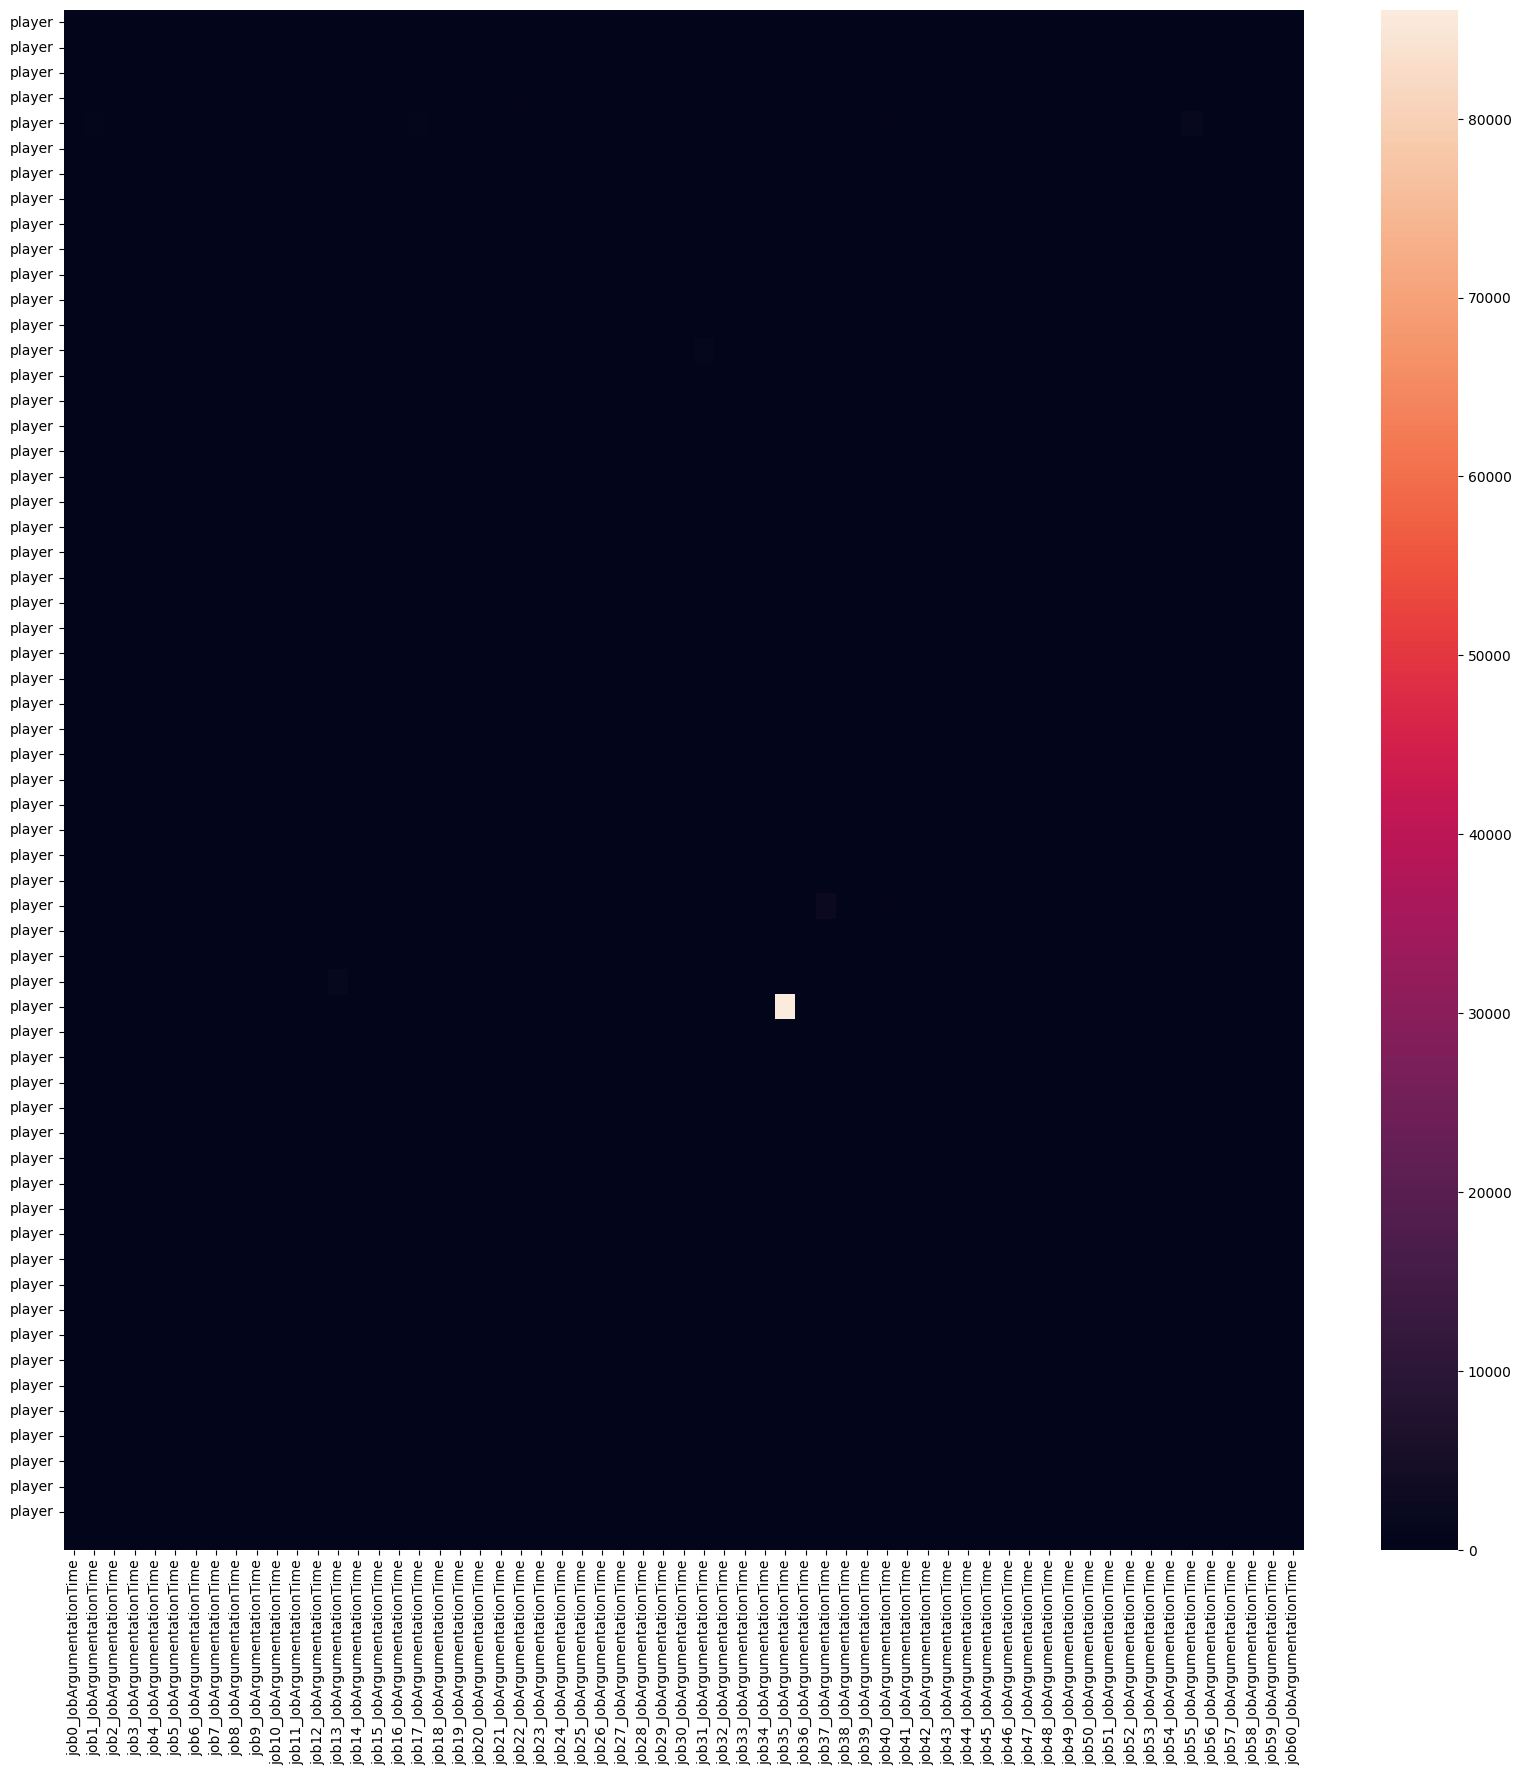

In [58]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
if Answer:
  sns.heatmap(df_Interested.loc[0:60, target_columns[1:]], yticklabels=df_Interested.SessionID[0:60], ax=ax)
else:
  sns.heatmap(df_Interested.loc[0:60, target_columns], yticklabels=df_Interested.SessionID[0:60], ax=ax)


## Some aggregate feature visualization

### Cleaning for visualizations

In [23]:
target = 'job' #@param {type:"string"}
target_columns = df_session.columns[~df_session.columns.str.contains(target)]
df_Aggregate = df_session[target_columns].copy()

In [24]:
df_Aggregate.head()

index        PlayerID  SessionCount        ActiveTime   
0      1      AbruptSign             1           0:01:32  \
1      2   AbsorbedComma             6   1 day, 22:19:00   
2      3   AbstractRobin             2  -1 day, 23:12:25   
3      4  AccusingSonnet             5  -3 days, 2:41:08   
4      5       AcidHumor            32   2 days, 6:11:09   

                                       JobsCompleted  SessionDiveSitesCount   
0                                                 []                      0  \
1  ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                     12   
2  ['kelp-urchin-barren-viz', 'kelp-musselfest-so...                     10   
3  ['arctic-seal-habitats', 'arctic-salmon-monito...                      9   
4  ['coral-fake-fix', 'coral-lionfish-conspiracy'...                     11   

   SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
0                  0                 0    player                     0  \
1                  0                42    player                    33   
2                  0                24    player                    15   
3                  0                25    player                    16   
4                  0                42    player                    22   

   SwitchJobsCount                       TopJobCompletionDestinations   
0                0                                                 {}  \
1               82  {"kelp-welcome": {"kelp-bull-kelp-forest": ["A...   
2               36  {"kelp-urchin-barren-viz": {"kelp-musselfest-s...   
3               32  {"arctic-salmon-monitoring": {"coral-turtle-po...   
4               69  {"coral-fake-fix": {"coral-lionfish-conspiracy...   

                            TopJobSwitchDestinations TotalArgumentationTime   
0                                                 {}        0 days 00:00:00  \
1  {"no-active-job": {"arctic-missing-whale": ["A...        0 days 00:44:24   
2  {"no-active-job": {"arctic-missing-whale": ["A...        0 days 00:14:18   
3  {"no-active-job": {"coral-turtle-population": ...        0 days 00:25:36   
4  {"no-active-job": {"coral-stressed": ["AcidHum...        0 days 01:21:07   

    TotalDiveTime TotalExperimentationTime  UserAvgSessionDuration   
0 0 days 00:00:00          0 days 00:00:00                    92.0  \
1 0 days 00:11:17          0 days 00:50:29             5289.833333   
2 0 days 00:02:02          0 days 00:08:00                  5308.0   
3 0 days 00:03:17          0 days 00:08:53                  2271.0   
4 0 days 00:12:51          0 days 00:31:21              6748.03125   

   UserTotalSessionDuration  
0                        92  
1                     31739  
2                     10616  
3                     11355  
4                    215937

In [25]:
target_columns = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime', 'UserSessionCount', 'SessionJobsCompleted', 'SwitchJobsCount']
for col in ['ActiveTime', 'TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']:
  df_Aggregate[col] = df_Aggregate[col].dt.total_seconds()

AttributeError: Can only use .dt accessor with datetimelike values

KeyError: "['UserSessionCount'] not in index"

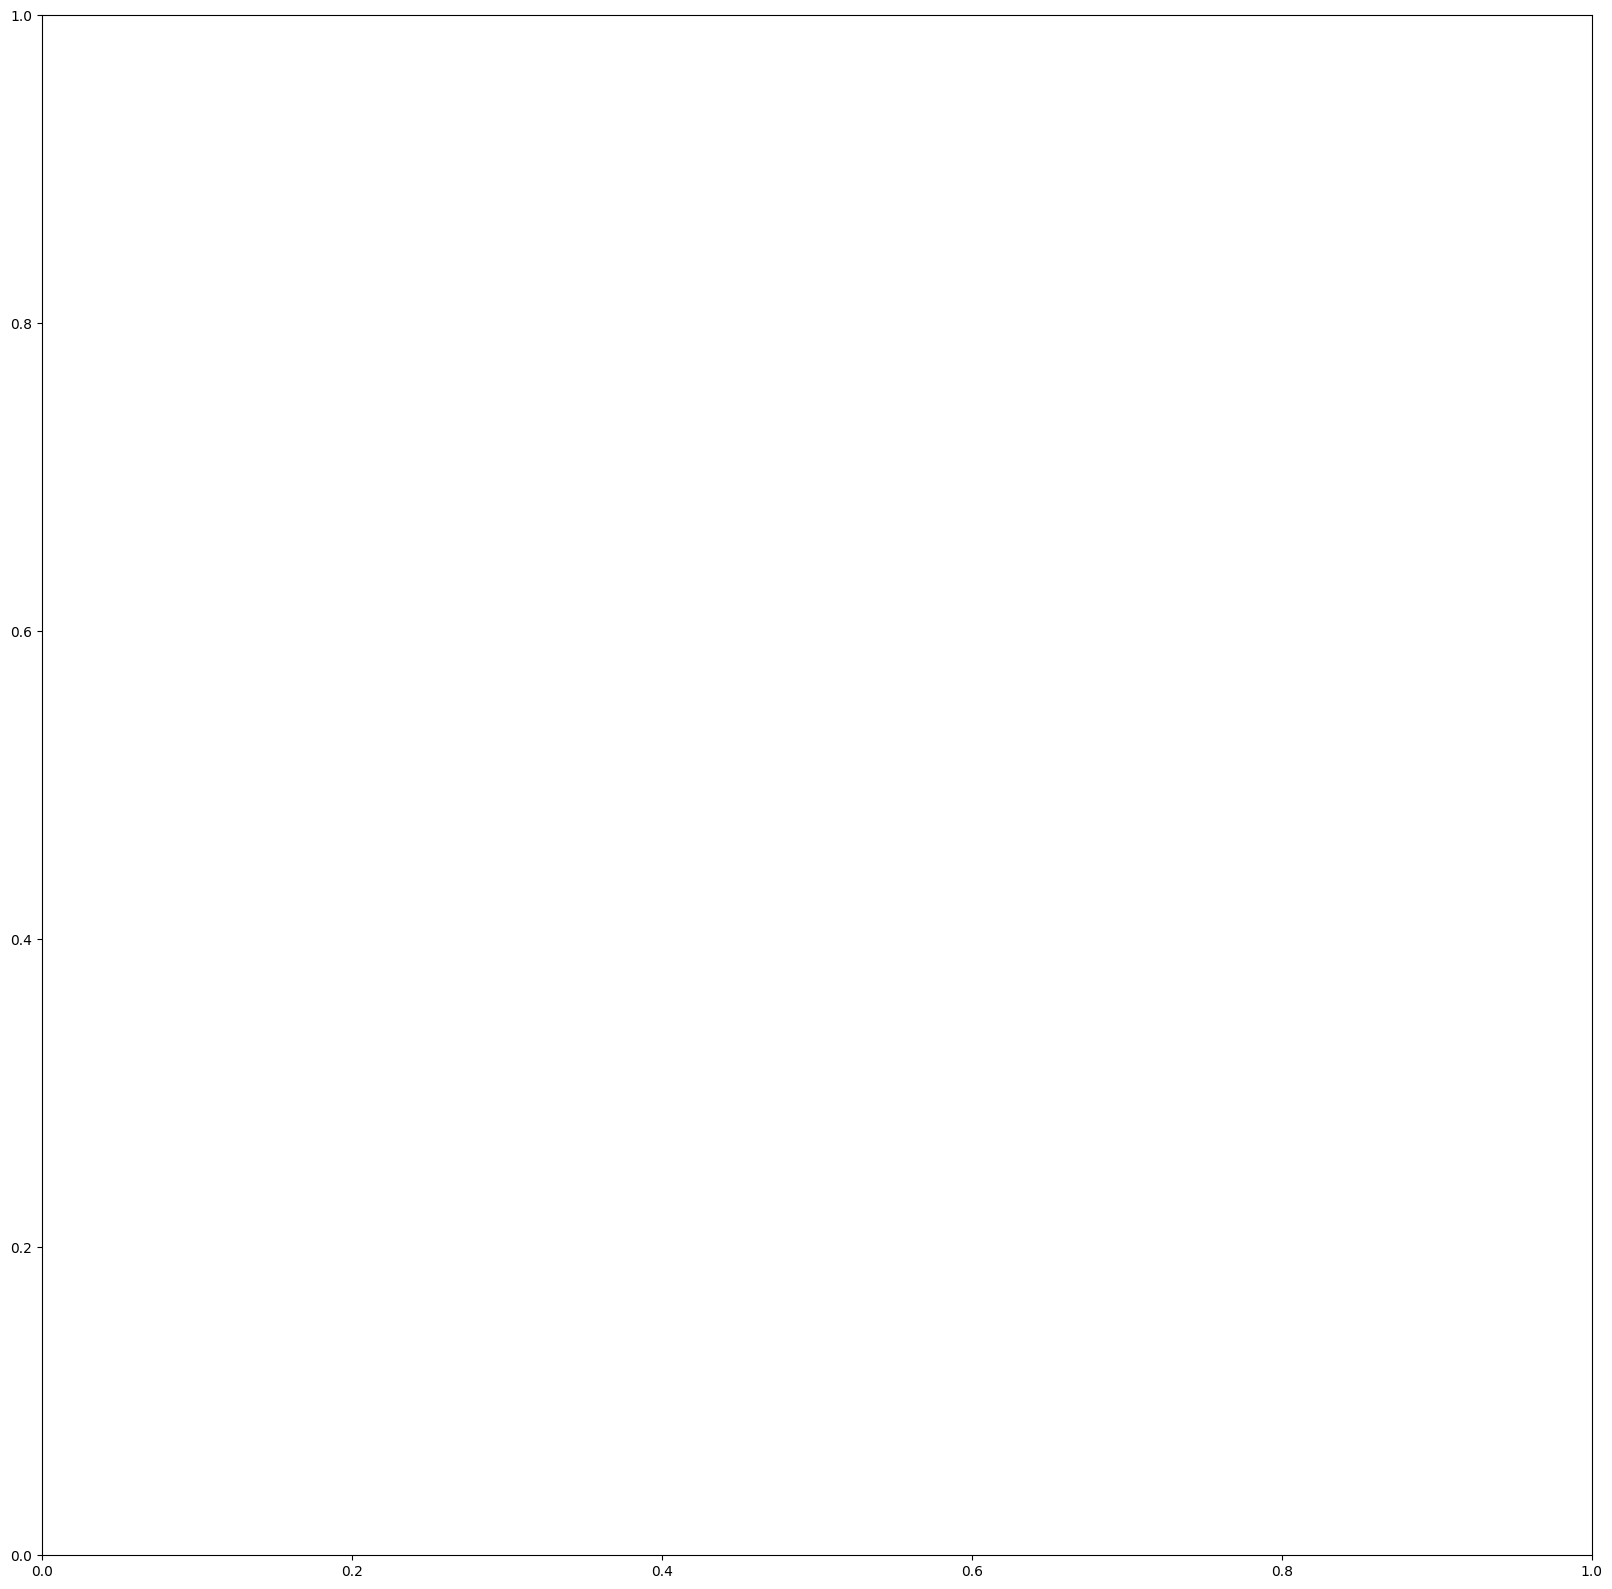

In [27]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

Here we find that there may be an outlier in TotalExperimentationTime feature. Let's remove it and impute with 0. For some other data, you can do your own cleaning and use other imputation method.

In [26]:
sec_outlier = 5000 #@param {type:"integer"}
df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > sec_outlier]

index       PlayerID  SessionCount        ActiveTime   
146    147    DailyGreens             2          22:13:20  \
248    249     GoldenMenu             4   1 day, 23:12:00   
304    305    LiteralView            12  3 days, 18:33:17   
592    593  ElevatedBugle             1           0:50:06   

                                         JobsCompleted  SessionDiveSitesCount   
146  ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                      9  \
248  ['kelp-shop-welcome', 'displaced-reef', 'coral...                     10   
304  ['turtle-danger2', 'bayou-boom-cause', 'bayou-...                     11   
592  ['arctic-missing-whale', 'arctic-disappearing-...                      3   

     SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
146                  0                15    player                    16  \
248                  0                 5    player                     6   
304                  0                30    player                    45   
592                  0                10    player                     4   

     SwitchJobsCount                       TopJobCompletionDestinations   
146               40  {"kelp-welcome": {"kelp-bull-kelp-forest": ["D...  \
248               23  {"kelp-shop-welcome": {"displaced-reef": ["Gol...   
304              109  {"turtle-danger2": {"bayou-boom-cause": ["Lite...   
592                9  {"arctic-missing-whale": {"arctic-disappearing...   

                              TopJobSwitchDestinations TotalArgumentationTime   
146  {"no-active-job": {"arctic-missing-whale": ["D...        0 days 00:22:04  \
248  {"no-active-job": {"coral-turtle-population": ...        0 days 00:17:10   
304  {"bayou-reef-decision": {"kelp-mussel-fest": [...        0 days 01:08:03   
592  {"bayou-alt-energy": {"arctic-seal-habitats": ...        0 days 00:06:17   

      TotalDiveTime TotalExperimentationTime  job0_JobActiveTime   
146 0 days 00:03:11          1 days 00:06:48                  11  \
248 0 days 00:13:33          0 days 21:49:59                  18   
304 0 days 00:06:39          0 days 01:34:34             1012923   
592 0 days 00:00:44          0 days 23:02:32                   0   

     job1_JobActiveTime  job2_JobActiveTime  job3_JobActiveTime   
146                1517                 392                   0  \
248                1335                   0                   0   
304                1049                 189                   0   
592                 391                   0                   0   

     job4_JobActiveTime  job5_JobActiveTime  job6_JobActiveTime   
146                  98                   0                   0  \
248                 399                   0                   0   
304                 664                   0                   0   
592                   0                   0                   0   

     job7_JobActiveTime  job8_JobActiveTime  job9_JobActiveTime   
146                   0                   0                   0  \
248                   0                   0                   0   
304                   0                   0                   0   
592                   0                   0                   0   

     job10_JobActiveTime  job11_JobActiveTime  job12_JobActiveTime   
146                    0                    0                    0  \
248                    0                    0                    0   
304                 2160                  680                  624   
592                    0                    0                    0   

     job13_JobActiveTime  job14_JobActiveTime  job15_JobActiveTime   
146                    0                  688                    0  \
248                    0                    0                    0   
304                  151                  390                  235   
592                    0                    0                    0   

     job16_JobActiveTime  job17_JobActiveTime  job18_JobActiveTime   
146      

In [ ]:
Experimentation_columns = df_session.columns[df_session.columns.str.contains("JobExperimentation")]
temp = df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > sec_outlier, Experimentation_columns]
temp

job0_JobExperimentationTime job1_JobExperimentationTime  \
169                      0 days                      0 days   

    job2_JobExperimentationTime job3_JobExperimentationTime  \
169                      0 days                      0 days   

    job4_JobExperimentationTime job5_JobExperimentationTime  \
169                      0 days                      0 days   

    job6_JobExperimentationTime job7_JobExperimentationTime  \
169                      0 days                      0 days   

    job8_JobExperimentationTime job9_JobExperimentationTime  \
169                      0 days                      0 days   

    job10_JobExperimentationTime job11_JobExperimentationTime  \
169                       0 days                       0 days   

    job12_JobExperimentationTime job13_JobExperimentationTime  \
169                       0 days                       0 days   

    job14_JobExperimentationTime job15_JobExperimentationTime  \
169                       0 days                       0 days   

    job16_JobExperimentationTime job17_JobExperimentationTime  \
169                       0 days                       0 days   

    job18_JobExperimentationTime job19_JobExperimentationTime  \
169                       0 days                       0 days   

    job20_JobExperimentationTime job21_JobExperimentationTime  \
169                       0 days                       0 days   

    job22_JobExperimentationTime job23_JobExperimentationTime  \
169                       0 days                       0 days   

    job24_JobExperimentationTime job25_JobExperimentationTime  \
169                       0 days                       0 days   

    job26_JobExperimentationTime job27_JobExperimentationTime  \
169                       0 days                       0 days   

    job28_JobExperimentationTime job29_JobExperimentationTime  \
169              0 days 00:01:15                       0 days   

    job30_JobExperimentationTime job31_JobExperimentationTime  \
169                       0 days                       0 days   

    job32_JobExperimentationTime job33_JobExperimentationTime  \
169                       0 days                       0 days   

    job34_JobExperimentationTime job35_JobExperimentationTime  \
169                       0 days                       0 days   

    job36_JobExperimentationTime job37_JobExperimentationTime  \
169                       0 days                       0 days   

    job38_JobExperimentationTime job39_JobExperimentationTime  \
169                       0 days                       0 days   

    job40_JobExperimentationTime job41_JobExperimentationTime  \
169                       0 days                       0 days   

    job42_JobExperimentationTime job43_JobExperimentationTime  \
169                       0 days                       0 days   

    job44_JobExperimentationTime job45_JobExperimentationTime  \
169                       0 days                       0 days   

    job46_JobExperimentationTime job47_JobExperimentationTime  \
169                       0 days                       0 days   

    job48_JobExperimentationTime job49_JobExperimentationTime  \
169                       0 days                       0 days   

    job50_JobExperimentationTime job51_JobExperimentationTime  \
169                       0 days                       0 days   

    job52_JobExperimentationTime job53_JobExperimentationTime  \
169                       0 days                       0 days   

    job54_JobExperimentationTime job55_JobExperimentationTime  \
169                       0 days                       0 days   

    job56_JobExperimentationTime job57_JobExperimentationTime  \
169                       0 days                       0 days   

    job58_JobExperimentationTime job59_JobExperimentationTime  
169                       0 days                       0 days

Notice: I used a hacky approach to remove outliers here

In [ ]:
df_Aggregate.TotalExperimentationTime = df_Aggregate.TotalExperimentationTime.mask(df_Aggregate.TotalExperimentationTime>sec_outlier, 0)

TypeError: '>' not supported between instances of 'str' and 'int'

KeyError: "['UserSessionCount'] not in index"

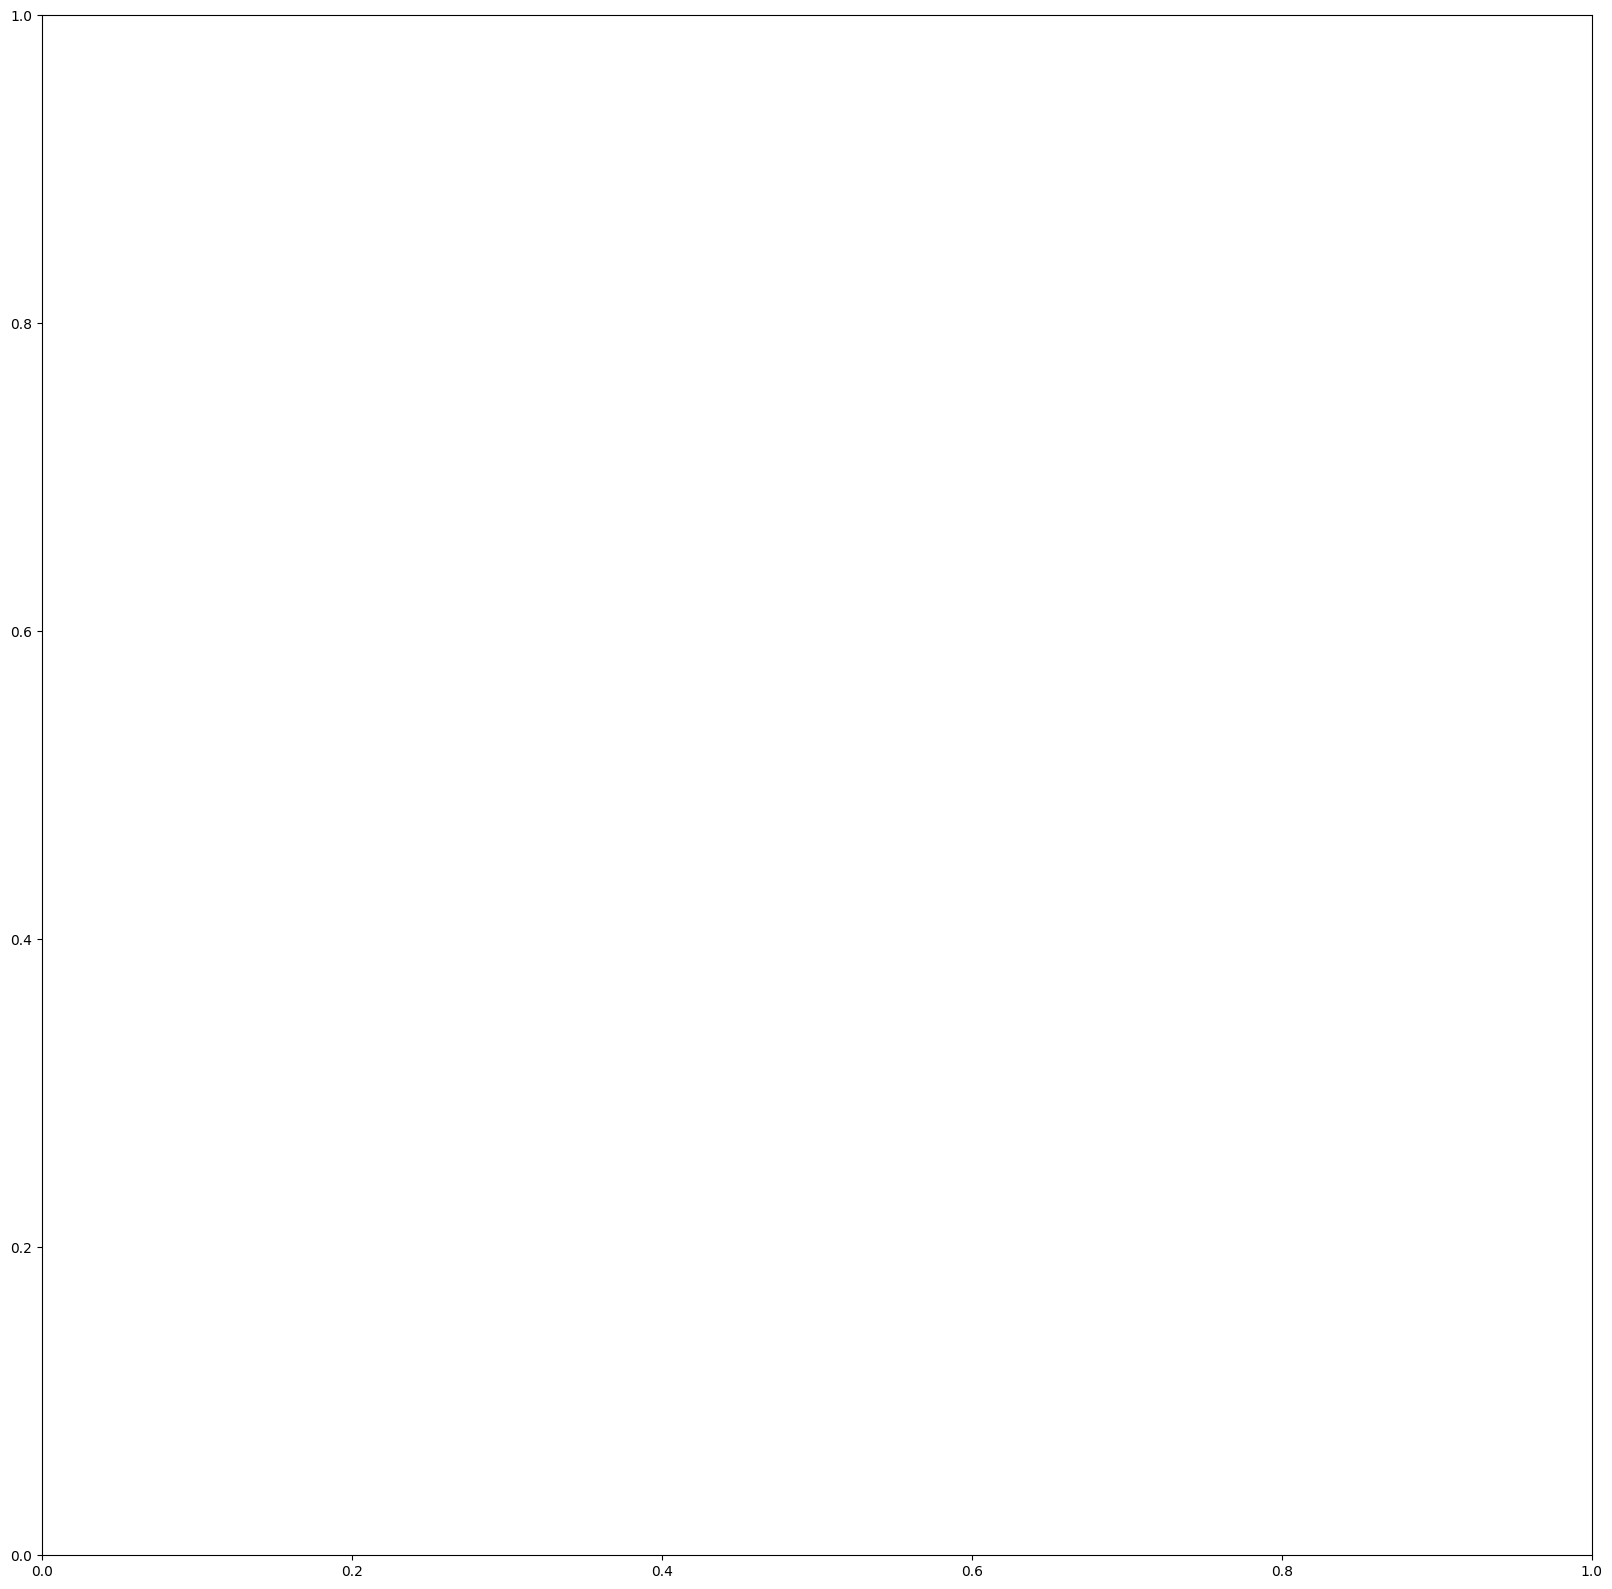

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

In [ ]:
#columns to compare with scatter plot
col1 = 'SessionJobsCompleted' #@param{type:"string"}
col2 = 'SwitchJobsCount'#@param{type:"string"}

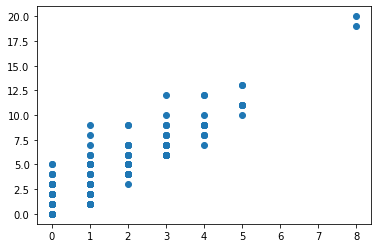

In [ ]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])

In [ ]:
#scatter plot columns
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

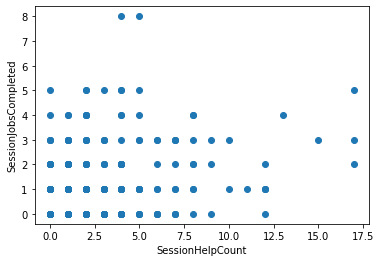

In [ ]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
plt.xlabel(col1)
plt.ylabel(col2)

You may want to see more advanced relationship via plots. Here is an example

Text(0, 0.5, 'SessionJobsCompleted/ActiveTime')

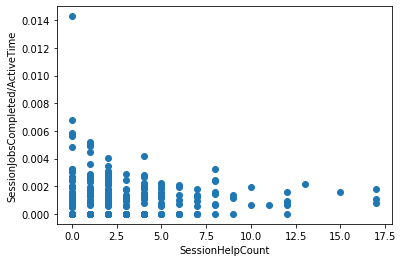

In [ ]:
#scatter plot comparing help to jobs_completed/active time
plt.scatter(df_Aggregate.SessionHelpCount, df_Aggregate.SessionJobsCompleted/df_Aggregate.ActiveTime)
plt.xlabel("SessionHelpCount")
plt.ylabel("SessionJobsCompleted/ActiveTime")

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [63]:
#@markdown Choose your own metric for test here
Group_column = "TotalDiveTime" #@param {type:'string'}
Dividing_value = "20" #@param {type: 'string'}
Interested_column = "TotalExperimentationTime" #@param {type: 'string'}

In [65]:
df_Aggregate['groups'] = df_Aggregate[Group_column].ge(Dividing_value)

In [68]:
df_Aggregate.shape
df_Aggregate

index        PlayerID  SessionCount        ActiveTime   
0        1      AbruptSign             1           0:01:32  \
1        2   AbsorbedComma             6   1 day, 22:19:00   
2        3   AbstractRobin             2  -1 day, 23:12:25   
3        4  AccusingSonnet             5  -3 days, 2:41:08   
4        5       AcidHumor            32   2 days, 6:11:09   
..     ...             ...           ...               ...   
949    950   WatchfulGuest             1           0:05:28   
950    951     WigglyMetro             1           0:02:11   
951    952        WildNote             2           2:49:38   
952    953   WishfulBasics             1           0:17:28   
953    954   WrittenRefund             1           0:00:53   

                                         JobsCompleted  SessionDiveSitesCount   
0                                                   []                      0  \
1    ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                     12   
2    ['kelp-urchin-barren-viz', 'kelp-musselfest-so...                     10   
3    ['arctic-seal-habitats', 'arctic-salmon-monito...                      9   
4    ['coral-fake-fix', 'coral-lionfish-conspiracy'...                     11   
..                                                 ...                    ...   
949                                                 []                      0   
950                                                 []                      0   
951  ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                      4   
952          ['kelp-welcome', 'kelp-bull-kelp-forest']                      2   
953                                                 []                      0   

     SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
0                    0                 0    player                     0  \
1                    0                42    player                    33   
2                    0                24    player                    15   
3                    0                25    player                    16   
4                    0                42    player                    22   
..                 ...               ...       ...                   ...   
949                  0                 0    player                     0   
950                  0                 0    player                     0   
951                  0                 5    player                     3   
952                  0                 0    player                     2   
953                  0                 0    player                     0   

     SwitchJobsCount                       TopJobCompletionDestinations   
0                  0                                                 {}  \
1                 82  {"kelp-welcome": {"kelp-bull-kelp-forest": ["A...   
2                 36  {"kelp-urchin-barren-viz": {"kelp-musselfest-s...   
3                 32  {"arctic-salmon-monitoring": {"coral-turtle-po...   
4                 69  {"coral-fake-fix": {"coral-lionfish-conspiracy...   
..               ...                                                ...   
949                2                                                 {}   
950                1                                                 {}   
951                7  {"kelp-welcome": {"kelp-bull-kelp-forest": ["W...   
952                5  {"kelp-welcome": {"kelp-bull-kelp-forest": ["W...   
953                0                                                 {}   

                              TopJobSwitchDestinations TotalArgumentationTime   
0                                                   {}        0 days 00:00:00  \
1    {"no-active-job": {"arctic-missing-whale": ["A...        0 days 00:44:24   
2    {"no-active-job": {"arctic-missing-whale": ["A...        0 days 00:14:18   
3    {"no-active-job": {"coral-turtle-population": ...        0 days 00:25:36   
4    {"no-active-job": {"coral-stressed": ["AcidHum...        0 days

In [28]:
pairwise = pairwise_tukeyhsd(endog=df_Aggregate[Interested_column], groups=df_Aggregate.groups, alpha=0.05)
print(pairwise)

NameError: name 'Interested_column' is not defined

# Machine learning models with Scikit Learn

In [69]:
response = "SessionJobsCompleted"
predictors = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']

## preprocessing

In [70]:

x = df_Aggregate[predictors].values
y = df_Aggregate[response].values
std_x = StandardScaler().fit_transform(x)
std_y = StandardScaler().fit_transform(np.array(y)[:,np.newaxis])

## building model

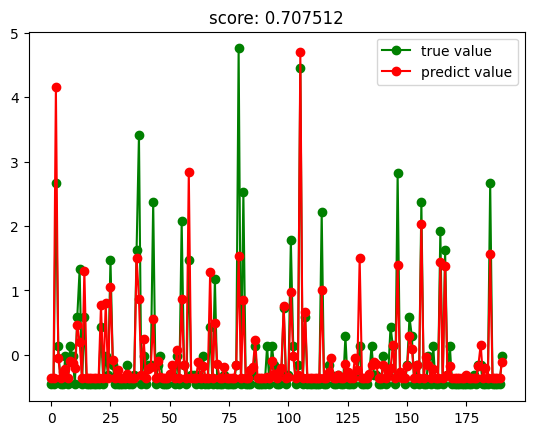

Bad pipe message: %s [b'\x1a\x89G\xb3\xa9\xbb%\x1e\x95eY\xf1\x18\xcbJ\x88\x05\xe3 f\xb4a\x04o\\\x9f\xd6\x17QB+\xa0\xfa\x1b\xcf[\x0c\x00\xbf\x9d\x08R\x1b\xe7\x9a\x94K L|Q\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01']
Bad pipe message: %s [b'']
Bad pipe message: %s [b"w\x98j7\x0f\x98{\xab\x0c\x9c\x1c\x15\x1cte\x02\x80\\\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0"]
Bad pipe

In [71]:
#linear regression model of train vs test
model = LR()
x_train, x_test, y_train, y_test = train_test_split(std_x, std_y, test_size=0.2, shuffle=True)
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
result = model.predict(x_test)
plt.figure()
plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
plt.title('score: %f'%score)
plt.legend()
plt.show()

## Cross validataion

In [ ]:
scores = cross_validate(model, x_train, y_train, cv=5, return_train_score=False)

print(scores.keys())
pprint(scores)

dict_keys(['fit_time', 'score_time', 'test_score'])
{'fit_time': array([0.00137472, 0.00104094, 0.00102544, 0.00101924, 0.00102067]),
 'score_time': array([0.00090504, 0.00081301, 0.00087929, 0.00085115, 0.000633  ]),
 'test_score': array([0.44654316, 0.27871589, 0.3589748 , 0.15790215, 0.3927793 ])}


# Deep Neural network with Keras

## Classification tasks

### Spliting data

In [ ]:
df_NN = df_Aggregate.copy()

In [ ]:
Predictors = ['TotalArgumentationTime', 'TotalExperimentationTime',
              'SessionDiveSitesCount',
              'ActiveTime', 'SessionHelpCount']
Responses = ['SessionJobsCompleted', "TotalDiveTime"]
cut_value = [1, 20]

In [ ]:
for r, v in zip(Responses, cut_value):
  df_NN['group_'+r] = (df_NN[r] > v).astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
X = df_NN[Predictors]
y = df_NN[['group_' + r for r in Responses]]
X_norm = (X - X.min())/(X.max() - X.min())
X_norm = np.asarray(X_norm).astype('float32')
y_norm = (y - y.min())/(y.max() - y.min())
x_train_full, x_test, y_train_full, y_test = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2, shuffle=True)
x_train.shape

(243, 5)

### Training models

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(y_train.shape[1], activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 300)               1800      
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 32,102
Trainable params: 32,102
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.003),
              metrics=[keras.metrics.binary_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=40)

Epoch 1/30
7/7 [==============================] - 1s 44ms/step - loss: 0.6925 - binary_accuracy: 0.7366 - val_loss: 0.6908 - val_binary_accuracy: 0.6885
Epoch 2/30
7/7 [==============================] - 0s 9ms/step - loss: 0.6912 - binary_accuracy: 0.7366 - val_loss: 0.6898 - val_binary_accuracy: 0.6885
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6899 - binary_accuracy: 0.7366 - val_loss: 0.6889 - val_binary_accuracy: 0.6885
Epoch 4/30
7/7 [==============================] - 0s 10ms/step - loss: 0.6889 - binary_accuracy: 0.7366 - val_loss: 0.6879 - val_binary_accuracy: 0.6885
Epoch 5/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6876 - binary_accuracy: 0.7366 - val_loss: 0.6868 - val_binary_accuracy: 0.6885
Epoch 6/30
7/7 [==============================] - 0s 10ms/step - loss: 0.6864 - binary_accuracy: 0.7366 - val_loss: 0.6858 - val_binary_accuracy: 0.6885
Epoch 7/30
7/7 [==============================] - 0s 9ms/step - loss: 0.6852 - binary

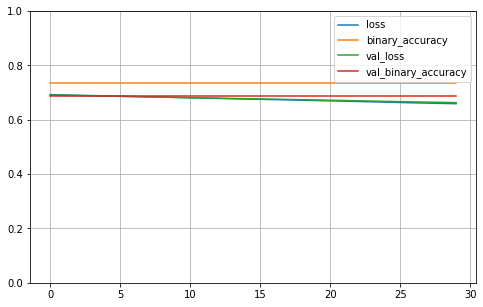

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# SOlution? REsolve

### Evaluation on the test data

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = model.predict(x_test[:3])
print("predictions:", predictions)
print("target_values:", y_test[:3])

Evaluate on test data
3/3 [==============================] - 0s 4ms/step - loss: 0.6508 - binary_accuracy: 0.7697
test loss, test acc: [0.6508499979972839, 0.7697368264198303]
Generate predictions for 2 samples
1/1 [==============================] - 0s 90ms/step
predictions: [[0.4546385  0.47081777]
 [0.45546988 0.467019  ]
 [0.45321342 0.46375987]]
target_values:      group_SessionJobsCompleted  group_TotalDiveTime
361                         0.0                  0.0
322                         0.0                  0.0
124                         1.0                  0.0


In [ ]:
predictions = model.predict(x_test)

3/3 [==============================] - 0s 6ms/step


Take SessionJobsCompleted as an example

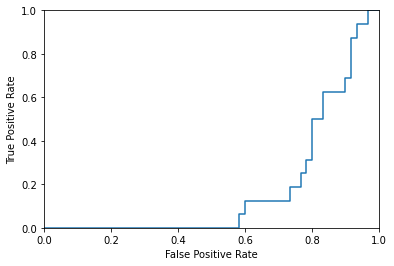

In [ ]:
fpr , tpr , thresholds = roc_curve (y_true=y_test.iloc[:,0], y_score=predictions[:,0])
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show() 

In [ ]:
print("auc score: ", roc_auc_score(y_test.iloc[:,0], predictions[:,0]))

auc score:  0.18229166666666669
